<a href="https://colab.research.google.com/github/ShivangiSharma77/DiscoveringDataScience/blob/main/AudioClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Audio Classification

##Installation

In [ ]:
!pip install -q pydub

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense
from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm

print(tf.__version__)
print(tfds.__version__)


2.5.0
4.0.1


In [ ]:
dataset =  tfds.load("gtzan_music_speech")

## Data exploration

In [ ]:
train = dataset["train"]
idata = iter(train)

In [ ]:
ex = next(idata)
ex

{'audio': <tf.Tensor: shape=(661500,), dtype=int64, numpy=array([-2821, -3743, -4288, ...,  -717,   132,  1548])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'vlobos.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

In [ ]:
audio = ex.get("audio")
label = ex.get("label")

Audio(audio, rate= 22050)

In [ ]:
index_class = {0: "music", 1: "speech"}
class_index = {"music" : 0, "speech": 1}

In [ ]:
def plot_wave(audio):
  plt.plot(audio)
  plt.xlabel("samples")
  plt.ylabel("amplitude")
  plt.show()

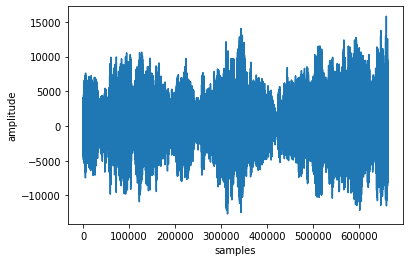

In [ ]:
plot_wave(audio)

## Spectrogram

In [ ]:
def stft(audio, frame_length = 2048, frame_step=512, fft_length=256):
  return tf.signal.stft(
      tf.cast(audio, tf.float32),
      frame_length= frame_length,
      frame_step= frame_step,
      fft_length= fft_length
  )



In [ ]:
audio_stft = stft(audio)
audio_spec = tf.abs(audio_stft)

In [ ]:
def spec(spec):
  plt.figure(figsize=(12,14))
  plt.imshow(tf.transpose(spec), cmap= "viridis")
  plt.colorbar()
  plt.show()

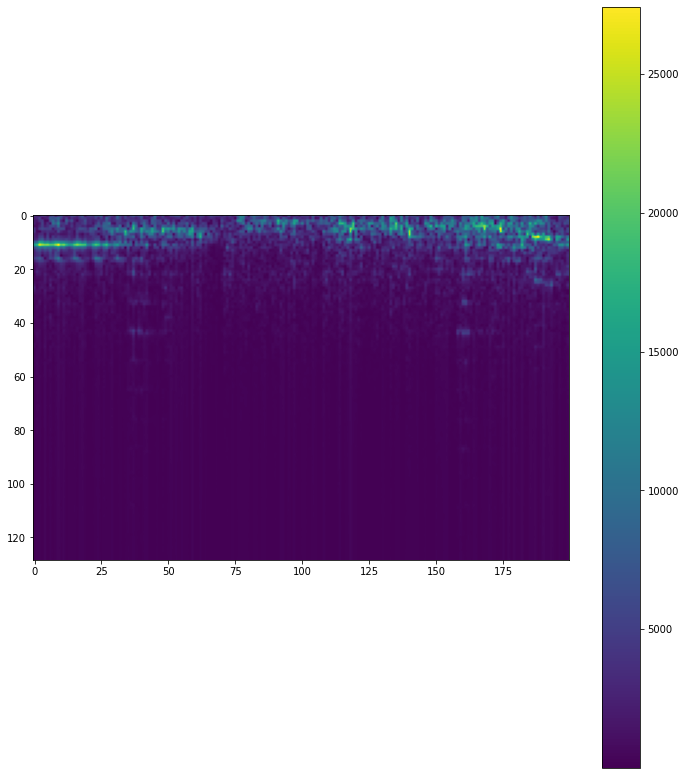

In [ ]:
spec(audio_spec[:200])

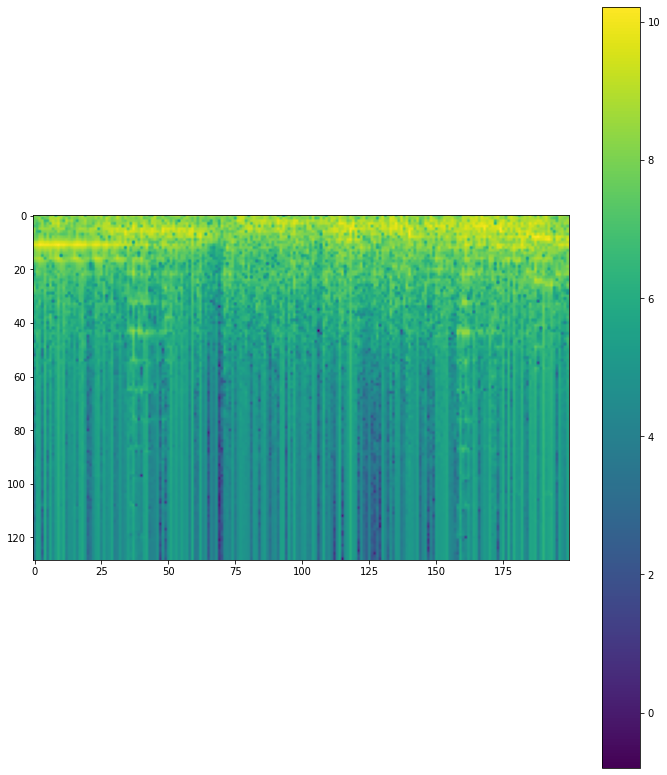

In [ ]:
audio_spec_log = tf.math.log(audio_spec)
spec(audio_spec_log[:200])

In [ ]:
def spectrogram(audio):
  audio_stft = stft(audio)
  audio_spec = tf.abs(audio_stft)
  return tf.math.log(tf.transpose(audio_spec))


## Data Prepration

In [ ]:
sr =22050 #sample per seconds
chunk = 5 # seconds
def preprocess(ex):
  audio = ex.get("audio")
  label = ex.get("label")
  x_batch, y_batch = None,None
  for i in range (0, 6):
      start = i * chunk * sr
      end = (i + 1) * chunk * sr
      audio_chunk = audio[start: end]
      audio_spec = spectrogram(audio_chunk)
      audio_spec = tf.expand_dims(audio_spec, axis=0)
      current_label = tf.expand_dims(label, axis=0)
      x_batch = audio_spec if x_batch is None else tf.concat([x_batch, audio_spec], axis=0)
      y_batch = current_label if y_batch is None else tf.concat([y_batch, current_label], axis=0)
  return x_batch, y_batch


In [ ]:
x_train, y_train = None, None
for ex in tqdm(iter(train)):
    x_batch, y_batch = preprocess(ex)
    x_train = x_batch if x_train is None else tf.concat([x_train, x_batch], axis=0)
    y_train= y_batch if y_train is None else tf.concat([y_train, y_batch], axis=0)



128it [00:04, 27.61it/s]


In [ ]:
print(x_train.shape, y_train.shape)

(768, 129, 212) (768,)


In [ ]:
indices = tf.random.shuffle(list(range(0, 768)))
x_train = tf.gather(x_train, indices)
y_train = tf.gather(y_train, indices)
n_val = 300
x_valid=x_train[:n_val, ...]
x_valid=x_train[:n_val, ...]
x_train = x_train[:n_val, ...]
y_train = y_train[:n_val, ...]

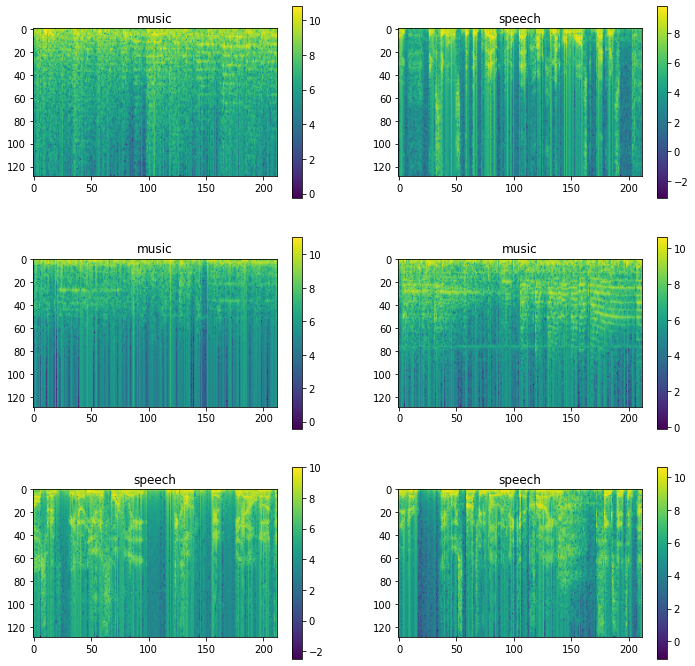

In [ ]:
plt.figure(figsize=(12,12))
st=0
for i in range(0,6):
  x,y = x_train[st +i], y_train[st+i]
  plt.subplot(3,2,i+1)
  plt.imshow(x, cmap="viridis")
  plt.title(index_class[y.numpy()])
  plt.colorbar()
plt.show()

## Create model

In [ ]:
input_ = Input(shape=(129, 212))
x = Lambda(lambda x: tf.expand_dims(x, axis=-1))(input_)
for i in range(0, 4):
  num_filters = 2**(5 + i)
  x = Conv2D(num_filters, 3)(x)
  x = BatchNormalization()(x)
  x = Activation("tanh")(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(input_,x)

In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer= tf.keras.optimizers.Adam(learning_rate=3e-6),
    metrics=["accuracy"]
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 129, 212)]        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 129, 212, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 127, 210, 32)      320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 127, 210, 32)      128       
_________________________________________________________________
activation_4 (Activation)    (None, 127, 210, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 105, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 103, 64)       1849

## Model Training

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, *args, **kwargs):
    super(CustomCallback, self).__init__(*args, **kwargs)
    self.target_acc = kwargs.get("target_acc") or 0.95
    self.log_epoch = kwargs.get("log_epoch") or 5
  def epoch_end(self, epoch, logs=None):
    loss = logs.get("loss")
    acc = logs.get("accuracy")
    val_loss = logs.get("val_loss")
    val_acc = logs.get("val_accuracy")
    if (epoch + 1) % self.log_epoch ==0:
      print(f"Epoch: {epoch:3d}, Loss: {loss: .4f}, Acc: {acc:.4f}, Val Loss: {val_loss: .4f},Val Acc: {val_acc: .4f}")
    if val_acc >= self.target_acc:
      print("Target val accuracy", val_acc)
      model.stop_training = True


In [ ]:
_ = model.fit(
    x_train, y_train, 
    # validation_data=None,
    batch_size=12,
    epochs=500,
    verbose=False,
    callbacks=[CustomCallback()]
)

## Prediction

In [ ]:
ex = next(idata)
x_test, y_test= preprocess(ex)
preds= model.predict(x_test)
pred_classes= tf.squeeze(tf.cast(preds > 0.5, tf.int8))

In [ ]:
pred_classes

<tf.Tensor: shape=(6,), dtype=int8, numpy=array([0, 0, 0, 0, 0, 0], dtype=int8)>

In [ ]:
y_test

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0])>